In [34]:
import numpy as np
import matplotlib.pyplot as plt
from src.satpos import *

In [35]:
def Log2sta(sol_log):
    sta=[]
    for i in range(len(sol_log)):
        keys=list(sol_log[i].keys())
        if(not len(keys)):
            continue
        gweek=sol_log[i][keys[0]]['GPSweek']
        gsec=sol_log[i][keys[0]]['GPSsec']
        sta_x=sol_log[i][keys[0]]['sta_x']
        sta_y=sol_log[i][keys[0]]['sta_y']
        sta_z=sol_log[i][keys[0]]['sta_z']
        sta_cdt=sol_log[i][keys[0]]['GPSsec_dt']
        sta_b,sta_l,sta_h=xyz2blh(sta_x,sta_y,sta_z)
        sta.append([gweek,gsec,sta_x,sta_y,sta_z,sta_cdt,sta_b,sta_l,sta_h])
    return np.array(sta)

#def CRD2STA(f_name):


sol_log_f="nav_result/WUH200CHN_R_20250350700_01H_30S_MO.25o.out.npy"
sol_log=np.load(sol_log_f,allow_pickle=True)

106


Text(0.5, 0, 'epoch       First fixed in epoch 106')

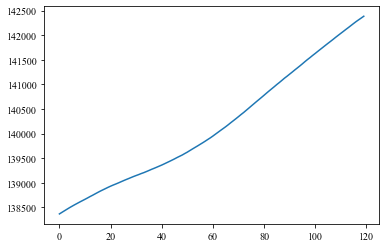

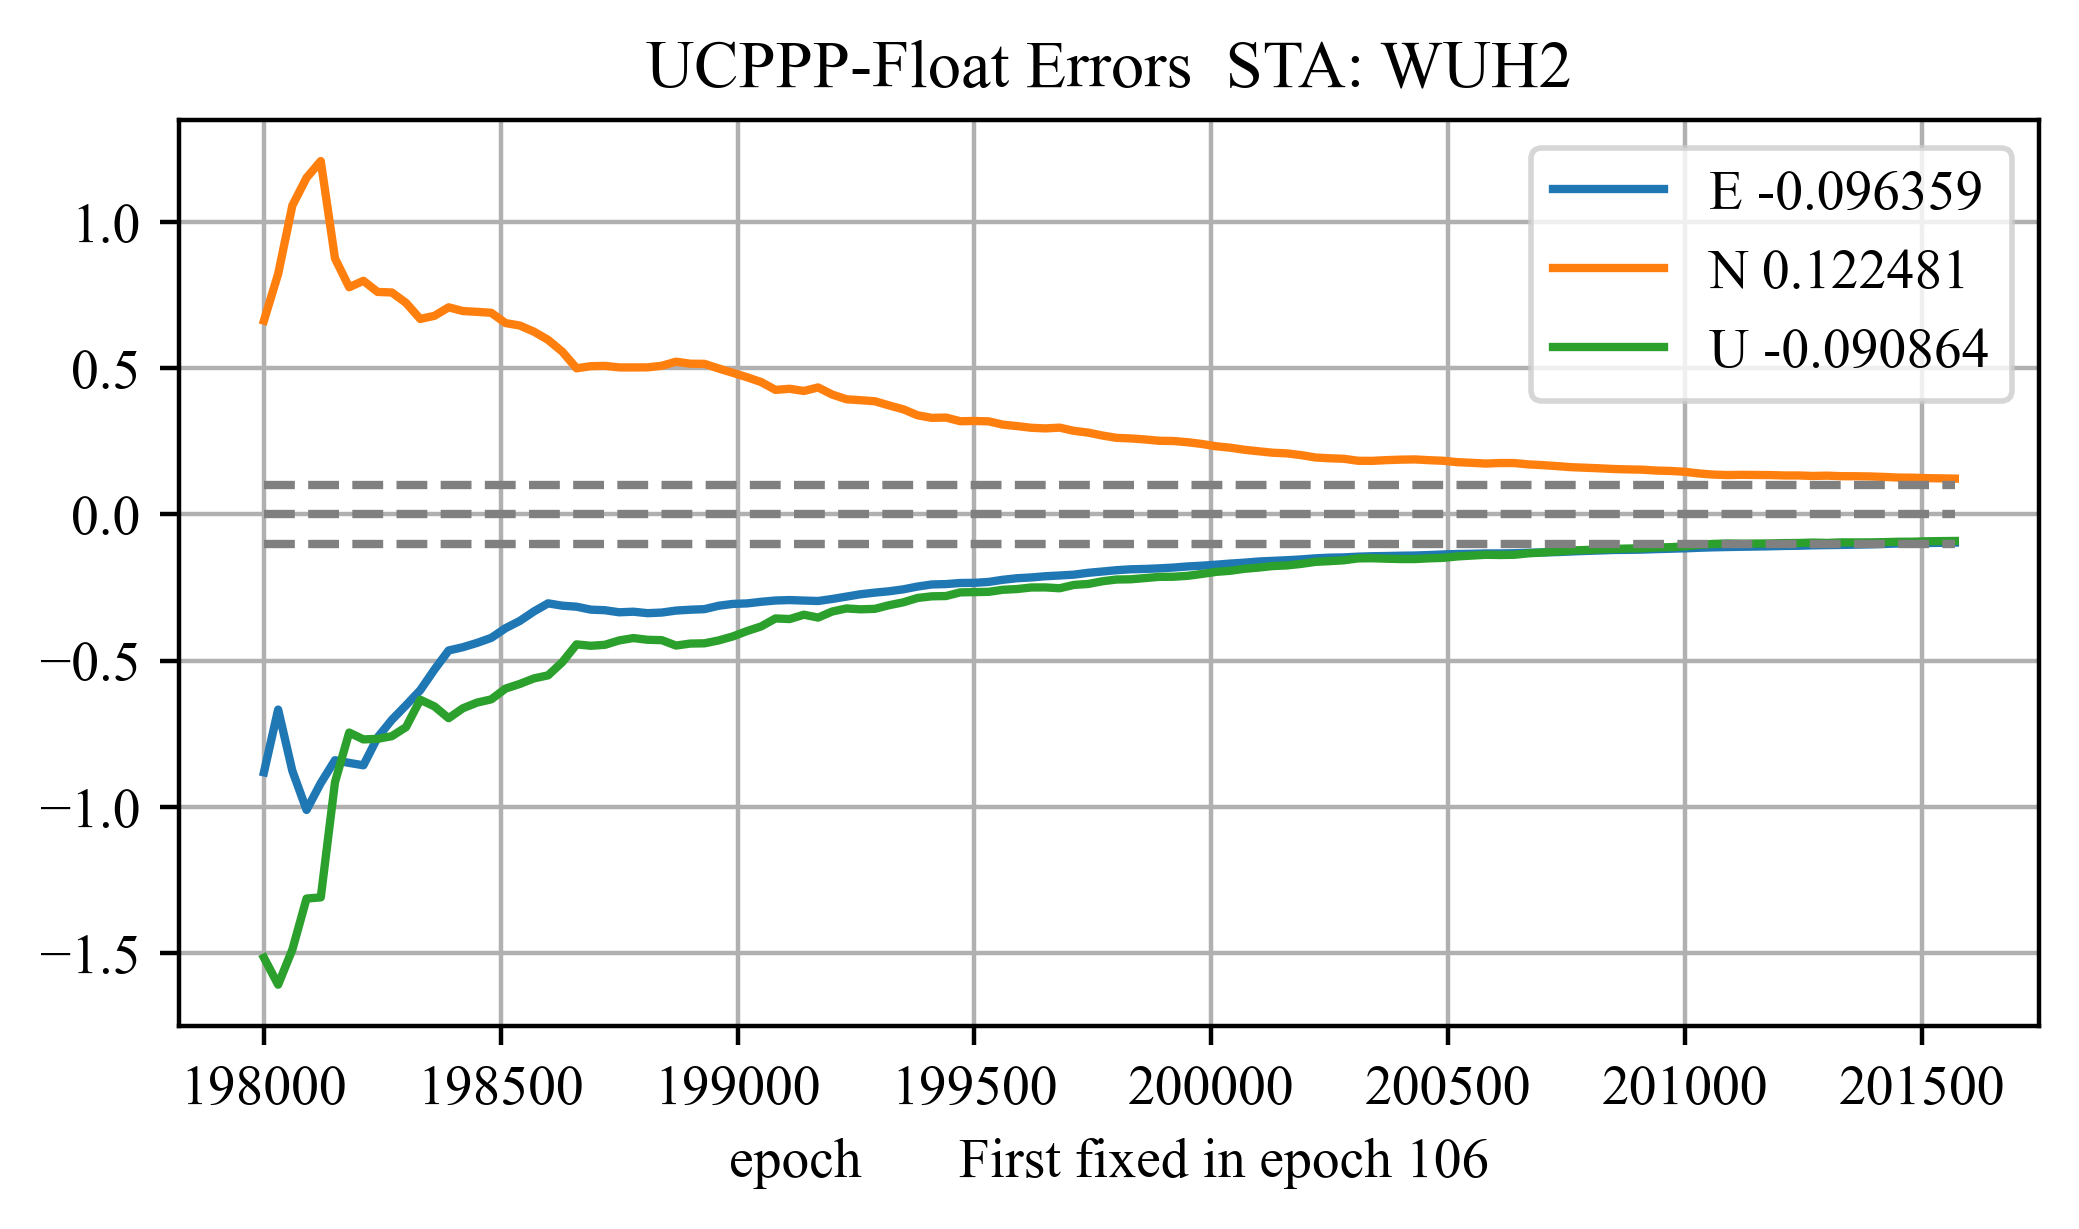

In [47]:
#绘图 误差图
#计算天线杆臂+ENU误差
STA=[-2.26775029554448e+06,  5.00915450062081e+06,  3.22129435928592e+06]
sta=Log2sta(sol_log)
denu=[0.0000,0.0000,0.1206]
denu=[0.0000,0.0000,0.0000]
#WUH2=[-1.59977668245623e+06,  5.24087892523863e+06,  3.25362542202429e+06]
''' 
  1474 STAX   WUH2  A    8 25:035:43200 m    2 -2.26775029554448e+06 0.00000e+00
  1475 STAY   WUH2  A    8 25:035:43200 m    2  5.00915450062081e+06 0.00000e+00
  1476 STAZ   WUH2  A    8 25:035:43200 m    2  3.22129435928592e+06 0.00000e+00
'''
plt.plot(sta[:,5])


enu=[]
for x in sta:
    enu_x=xyz2neu([x[2],x[3],x[4]],STA)
    enu_x=np.array(enu_x)+np.array(denu)
    enu_n=np.linalg.norm(xyz2neu([x[2],x[3],x[4]],STA))
    enu.append([x[0],x[1],enu_x[0],enu_x[1],enu_x[2],enu_n])
enu=np.array(enu)

#计算首次收敛时间
fix_epoch='failed'
for i in range(len(enu)):
    if((abs(enu[i][2])<=0.10 and abs(enu[i][3])<=0.10 and abs(enu[i][4])<=0.10) or ((enu[i][5])<=0.20)):
        fix_epoch=i
        break
print(fix_epoch)

plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.figure(dpi=400,facecolor="white",figsize=(6,3))

#plt.subplot(4,1,1)
#plt.plot([0,len(X_log)],[0.0,0.0],'--',c='grey')
plt.plot(enu[:,1],enu[:,2])
#plt.ylim(-3.0,3.0)
#plt.xticks([])

#plt.subplot(4,1,2)
#plt.plot([0,len(X_log)],[0.0,0.0],'--',c='grey')
plt.plot(enu[:,1],enu[:,3])
#plt.ylim(-3.0,3.0)
plt.grid('on')
#plt.xticks([])

#plt.subplot(4,1,3)

plt.plot(enu[:,1],enu[:,4])
#plt.ylim(-1.1,1.1)

plt.legend(["E {:4f}".format(np.mean(enu[-1,2])),"N {:4f}".format(np.mean(enu[-1,3])),"U {:2f}".format(np.mean(enu[-1,4]))])
plt.plot([sta[0][1],sta[-1][1]],[0.0,0.0],'--',c='grey')
plt.plot([sta[0][1],sta[-1][1]],[0.1,0.1],'--',c='grey')
plt.plot([sta[0][1],sta[-1][1]],[-0.1,-0.1],'--',c='grey')

plt.title("UCPPP-Float Errors  STA: {}".format(sol_log_f.split('/')[-1][:4]))
plt.xlabel("epoch       First fixed in epoch {}".format(fix_epoch))

In [42]:
np.linalg.norm(enu[-1,5])

0.18039646801617082

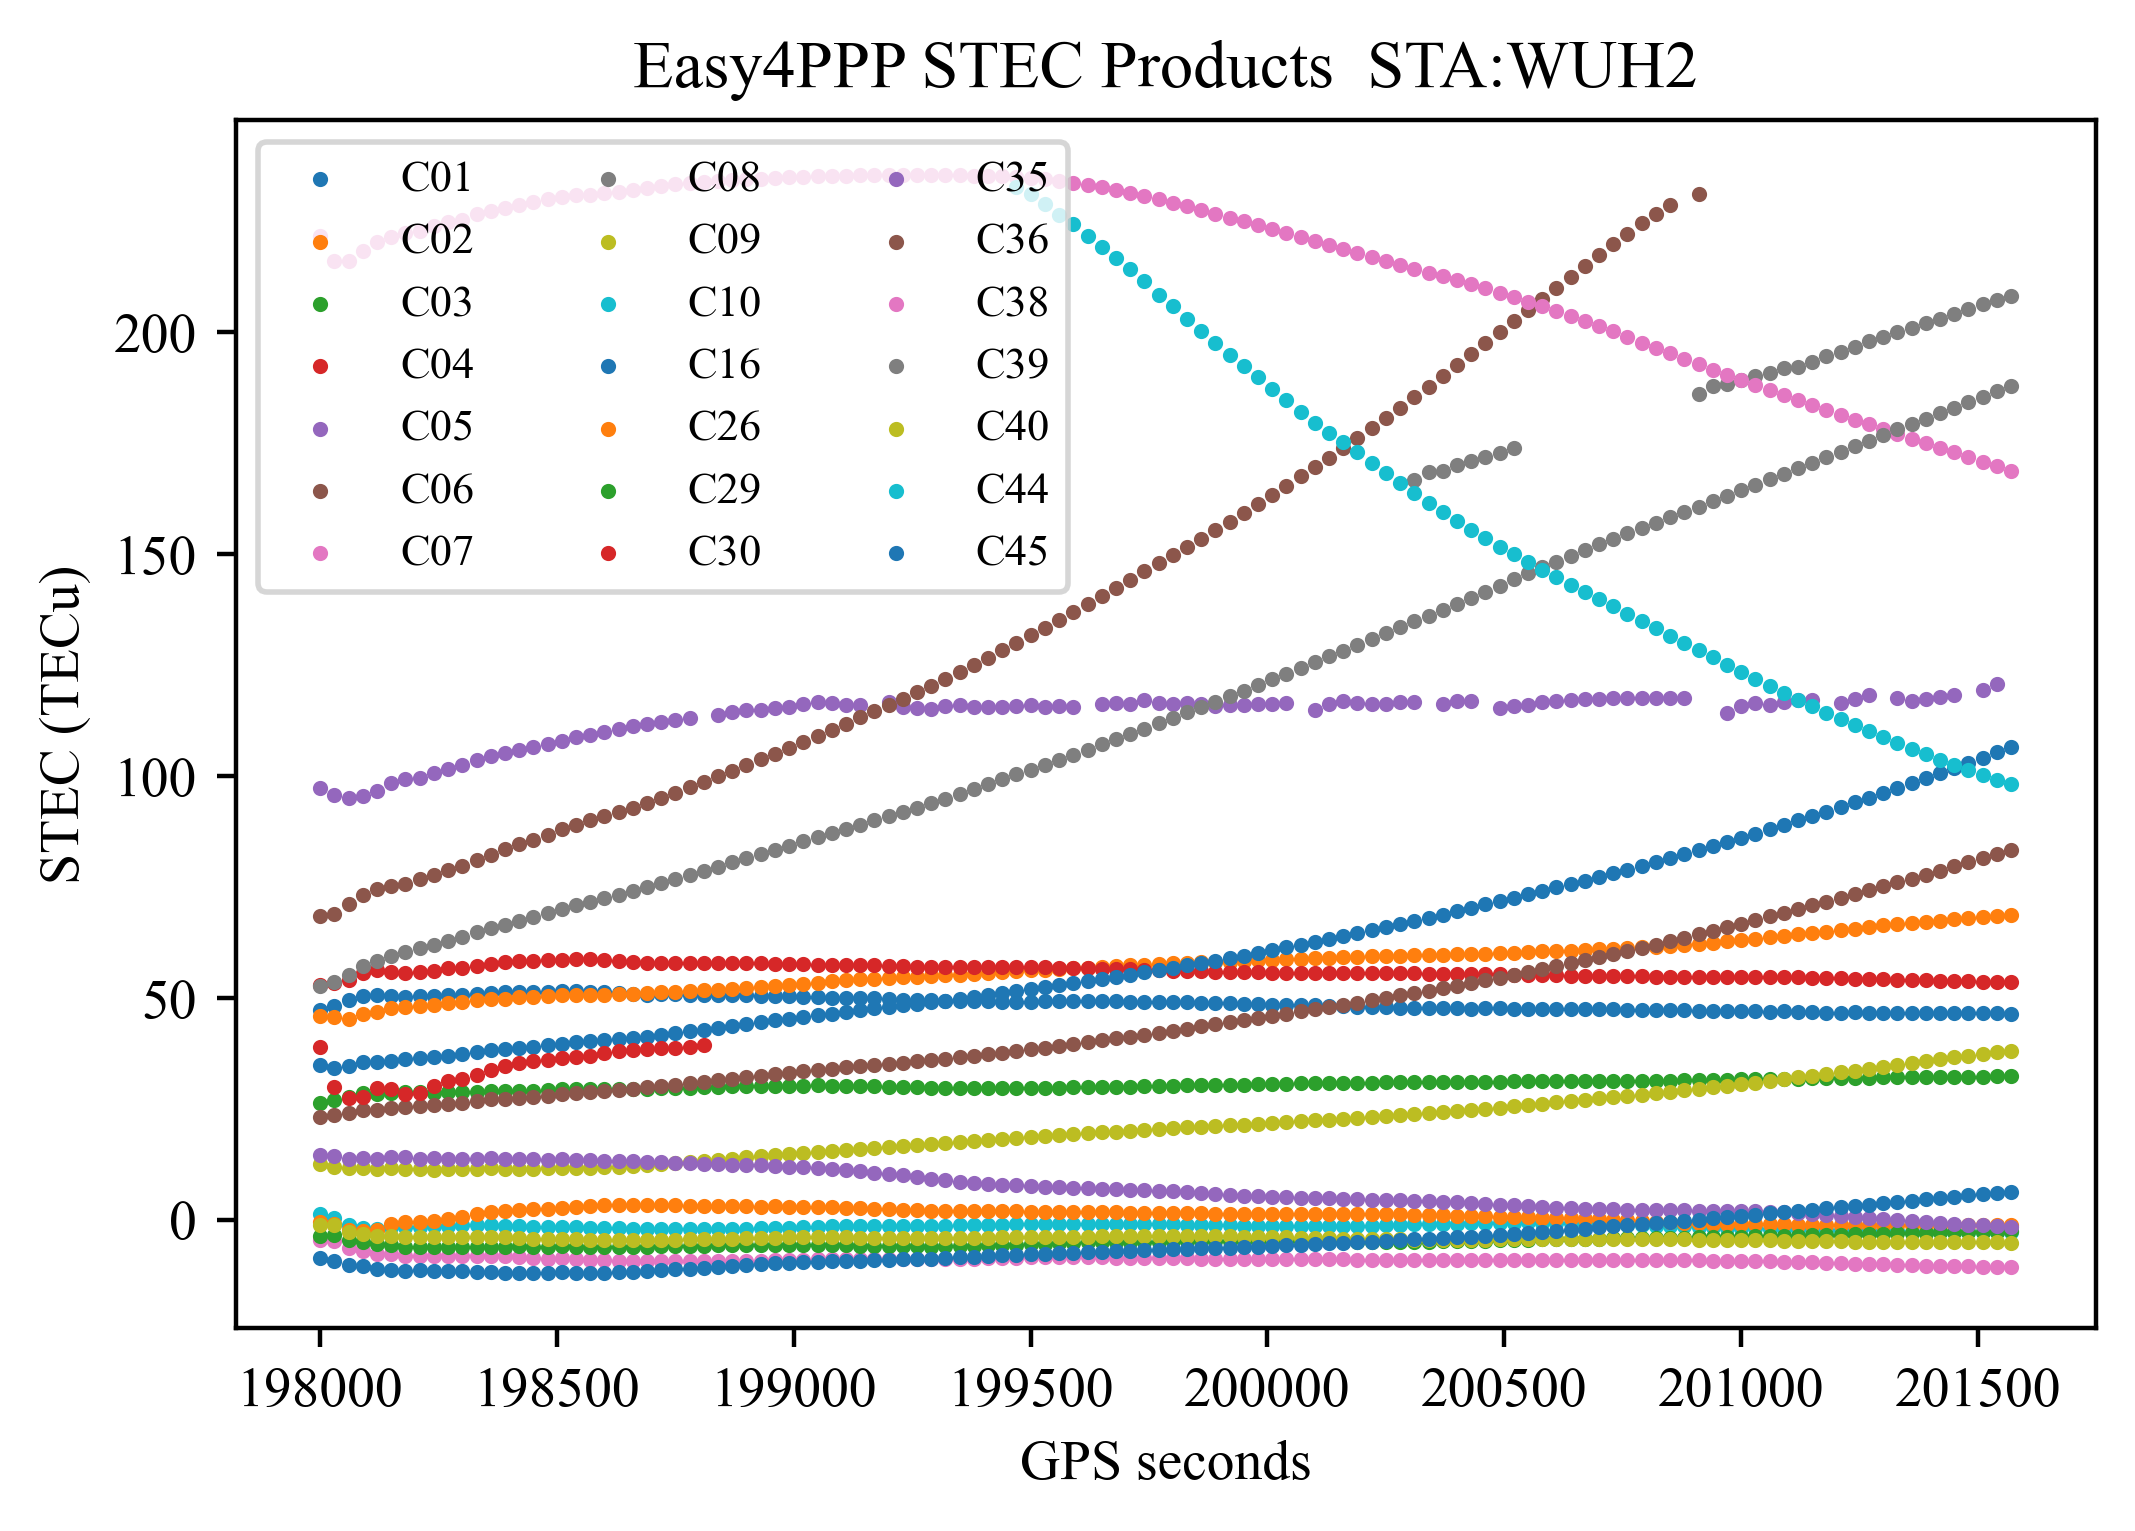

In [37]:
#绘图: STEC
import matplotlib.pyplot as plt

plt.figure(dpi=400)

sys_sat_num=65
sys_name='C'
legend=[]

for PRN in range(1,sys_sat_num+1):
    PRN=sys_name+"{:02d}".format(PRN)
    stec_list=[]
    i=0
    for out in sol_log:
        prns=list(out.keys())
        if(PRN in prns and'STEC' in list(out[PRN].keys())):
            #print(PRN,list(out[PRN].keys()))
            if(out[PRN]['std_STEC']<90000.0):
                GPSsec=out[PRN]['GPSsec']
                stec_list.append([GPSsec,out[PRN]['STEC']])
        i+=1
    #print(stec_list)
    
    if(len(stec_list)):
        plt.scatter(np.array(stec_list)[:,0],np.array(stec_list)[:,1],s=3)
        legend.append(PRN)

plt.ylabel("STEC (TECu)")
plt.xlabel("GPS seconds")
plt.title("Easy4PPP STEC Products  STA:{}".format(sol_log_f.split("/")[-1][:4]))
plt.legend(legend,ncol=3,fontsize=8)

(-10.0, 10.0)

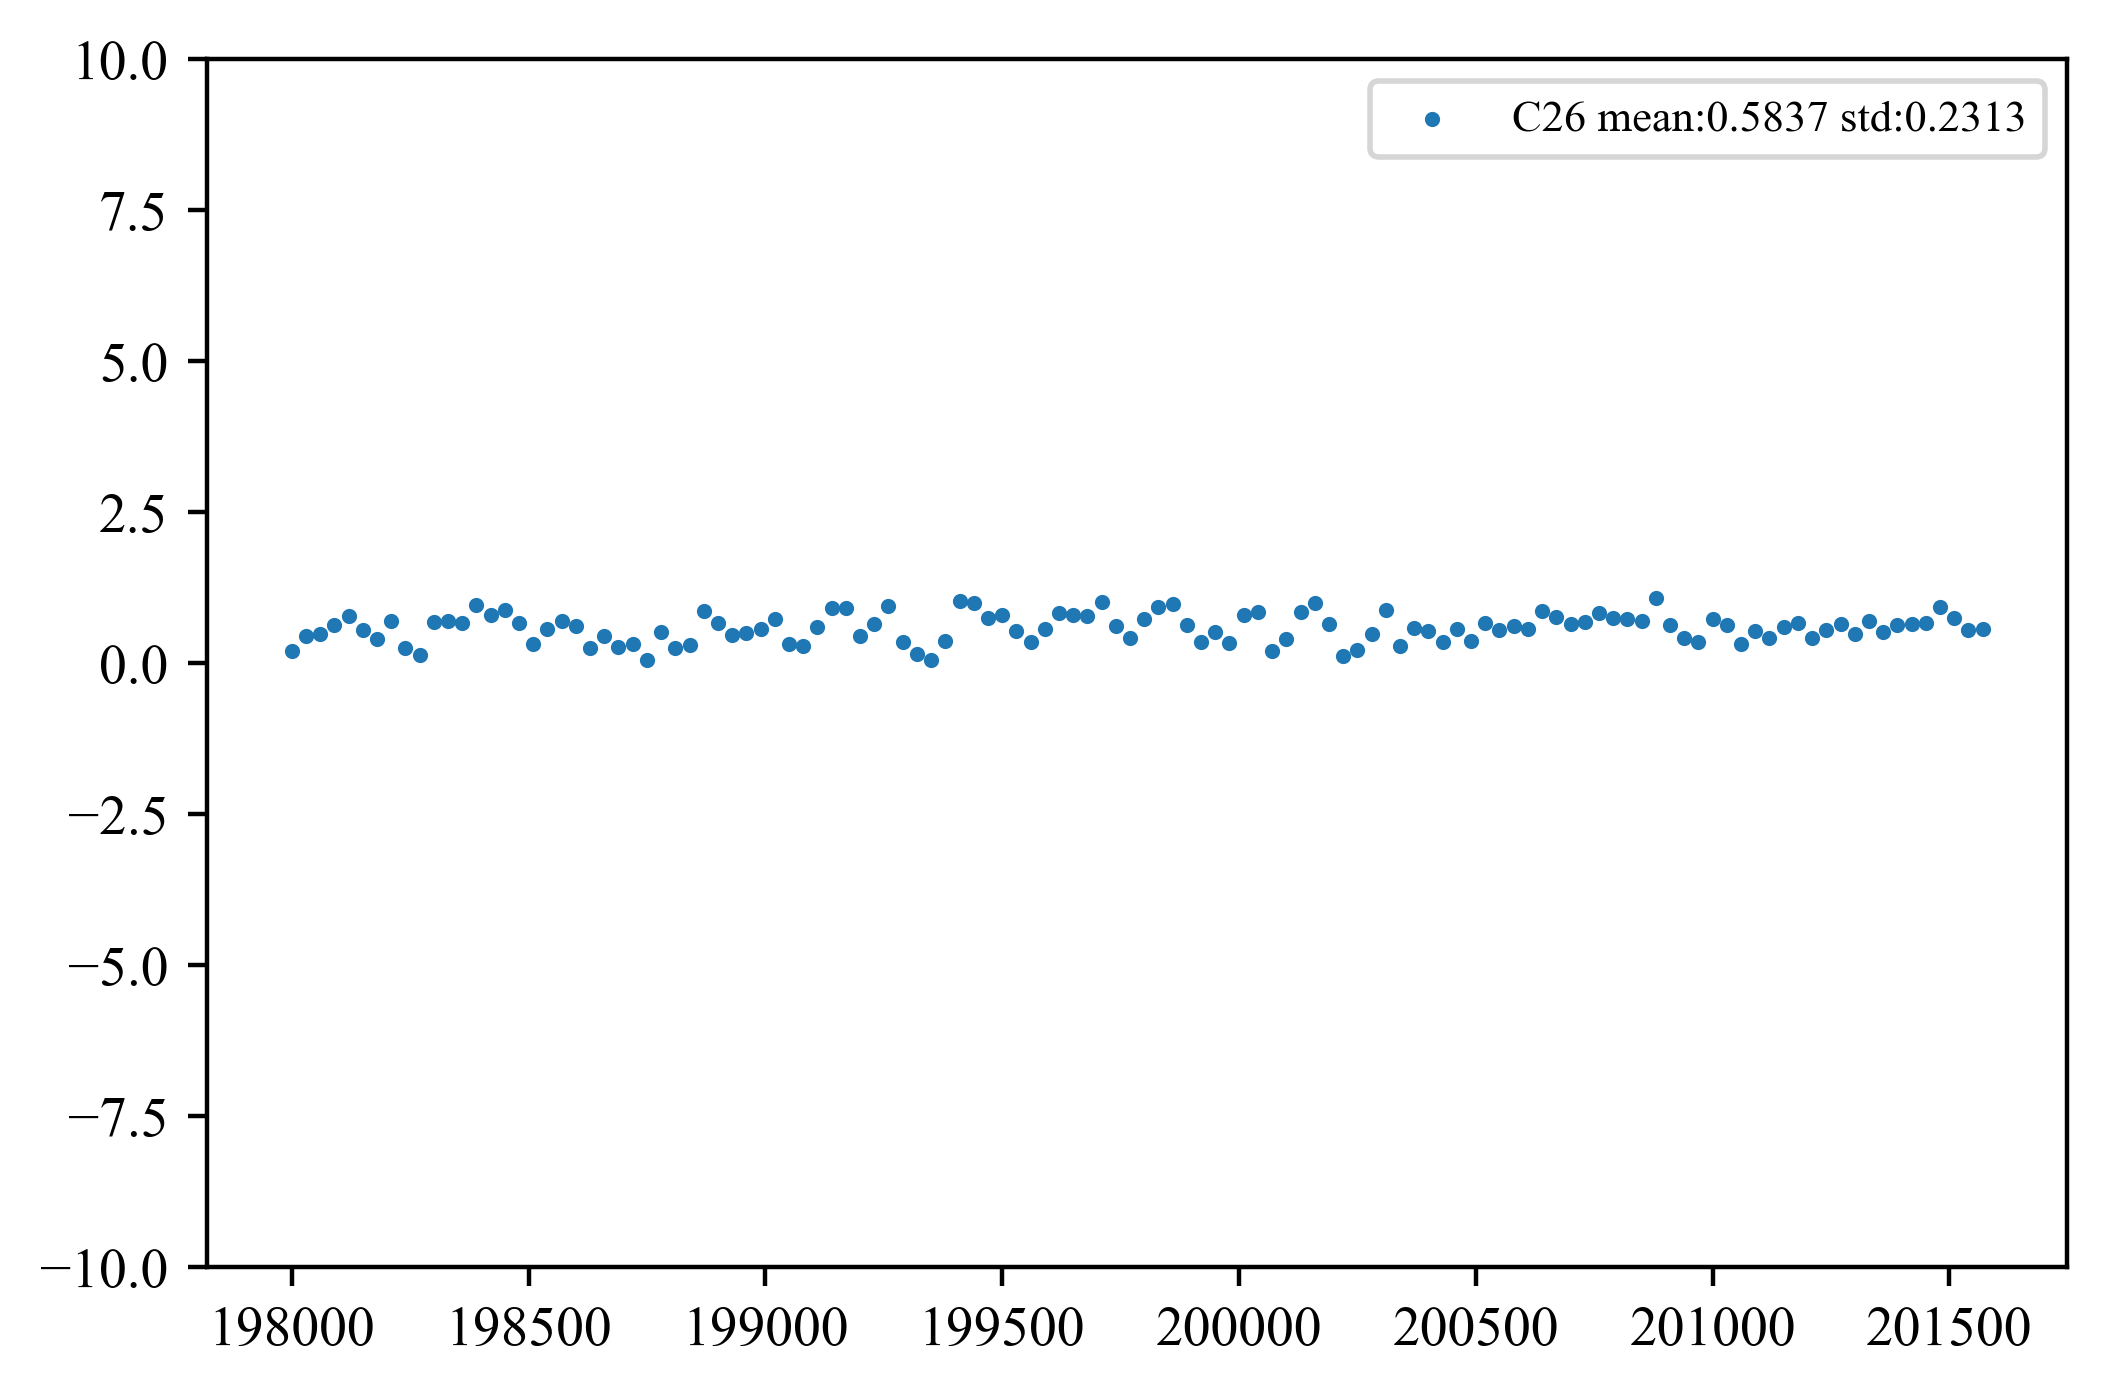

In [22]:
#绘图: res
import matplotlib.pyplot as plt

plt.figure(dpi=400)

sys_sat_num=32
sys_name='C'
legend=[]
target='res_p1'
target_prns=['C26']

for PRN in range(1,sys_sat_num+1):
    PRN=sys_name+"{:02d}".format(PRN)
    stec_list=[]
    for out in sol_log:
        if(len(target_prns)==0):
            prns=list(out.keys())
        else:
            prns=target_prns.copy()
        if(PRN in prns and PRN in list(out.keys())):
                if(target in list(out[PRN].keys())):
                #print(PRN,list(out[PRN].keys()))
                    GPSsec=out[PRN]['GPSsec']
                    stec_list.append([GPSsec,out[PRN][target][0]])
    #print(stec_list)
    
    if(len(stec_list)):
        plt.scatter(np.array(stec_list)[:,0],np.array(stec_list)[:,1],s=3)
        legend.append(PRN+' mean:{:.4f} std:{:.4f}'.format(np.mean(np.array(stec_list)[:,1]), np.std(np.array(stec_list)[:,1]) ) )
        #np.save('resp1_G07.npy',stec_list)
plt.legend(legend,ncol=3,fontsize=8)
plt.ylim(-10,10)